In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


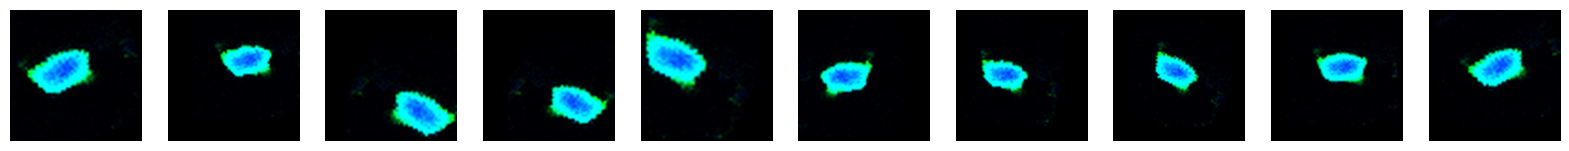

In [ ]:
import os
import shutil
from PIL import Image, ImageOps, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (224, 224)
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/data_ctr_GB'  # Path to the original dataset
AUGMENTED_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_ctr_GB'
NUM_AUGMENTATIONS = 10  # Number of augmentations per image

# Clean up any previous augmented data
if os.path.exists(AUGMENTED_DATASET_PATH):
    shutil.rmtree(AUGMENTED_DATASET_PATH)
os.makedirs(AUGMENTED_DATASET_PATH)

# Augmentation functions
def random_rotation(image):
    return image.rotate(np.random.uniform(-30, 30))

def random_flip(image):
    if np.random.rand() > 0.5:
        return ImageOps.mirror(image)
    return image

def random_shift(image):
    max_dx = 0.2 * image.size[0]
    max_dy = 0.2 * image.size[1]
    dx = np.random.uniform(-max_dx, max_dx)
    dy = np.random.uniform(-max_dy, max_dy)
    return image.transform(image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))

def random_zoom(image):
    scale = np.random.uniform(0.8, 1.2)
    w, h = image.size
    x = int(np.random.uniform(0, w*(1-scale)))
    y = int(np.random.uniform(0, h*(1-scale)))
    image = image.crop((x, y, x + int(w*scale), y + int(h*scale)))
    return image.resize(IMG_SIZE, Image.LANCZOS)

def augment_image(image):
    image = random_rotation(image)
    image = random_flip(image)
    image = random_shift(image)
    image = random_zoom(image)
    return image

# Function to augment and save images
def augment_and_save_images(source_dir, dest_dir):
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            dest_class_path = os.path.join(dest_dir, class_name)
            os.makedirs(dest_class_path, exist_ok=True)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    image = Image.open(img_path)
                except (UnidentifiedImageError, IsADirectoryError):
                    print(f"Skipping file {img_path} as it is not a valid image.")
                    continue
                for i in range(NUM_AUGMENTATIONS):
                    augmented_image = augment_image(image)
                    augmented_image.save(os.path.join(dest_class_path, f'aug_{i}_{img_name}'))

# Augment and save images
augment_and_save_images(DATASET_PATH, AUGMENTED_DATASET_PATH)

# Function to visualize augmented images
def visualize_augmented_images(augmented_dataset_path, num_images):
    image_paths = []
    for root, dirs, files in os.walk(augmented_dataset_path):
        for name in files:
            image_paths.append(os.path.join(root, name))

    # Display a few augmented images
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis('off')
    plt.show()

# Visualize the augmented images
visualize_augmented_images(AUGMENTED_DATASET_PATH, 10)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

In [ ]:
if tf.test.gpu_device_name():
  print('GPU is available')
else:
  print('GPU is not available')

GPU is available


Found 6916 images belonging to 3 classes.
Found 1729 images belonging to 3 classes.
Found 4322 images belonging to 3 classes.
Found 4323 images belonging to 3 classes.
58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/20
217/217 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.8003 - f1_score: 0.7947 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 2950s 14s/step - loss: 0.6666 - accuracy: 0.8003 - f1_score: 0.7947 - val_loss: 0.2260 - val_accuracy: 0.9262 - val_f1_score: 0.9242
Epoch 2/20
217/217 [==============================] - 73s 333ms/step - loss: 0.3830 - accuracy: 0.8937 - f1_score: 0.8936 - val_loss: 0.2768 - val_accuracy: 0.8901 - val_f1_score: 0.8887
Epoch 3/20
217/217 [==============================] - 76s 349ms/step - loss: 0.2490 - accuracy: 0.9264 - f1_score: 0.9268 - val_loss: 0.2722 - val_accuracy: 0.8869 - val_f1_score: 0.8839
Epoch 4/20
217/217 [==============================] - 88s 406ms/step - loss: 0.2034 - accuracy: 0.9396 - f1_score: 0.9418 - val_loss: 0.1829 - val_accuracy: 0.9424 - val_f1_score: 0.9426
Epoch 5/20
217/217 [==============================] - 75s 343ms/step - loss: 0.1486 - accuracy: 0.9530 - f1_score: 0.9535 - val_loss: 0.1869 - val_accuracy: 0.9292 - val_f1_score: 0.9296
Epoch 6/20
217/217 [==============================] - 88s 404ms/step - loss:

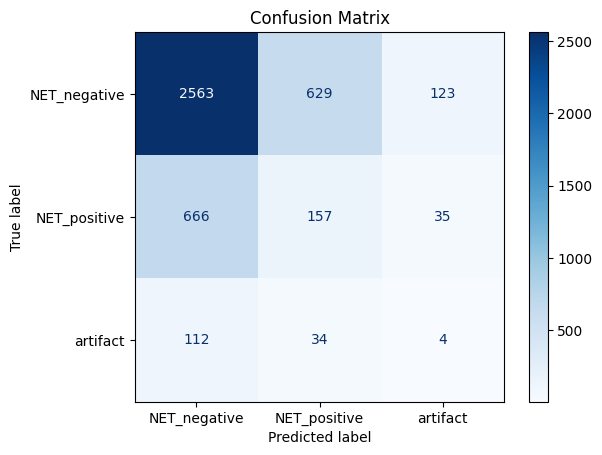

In [ ]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = 'vgg16_nets_model.h5'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_all'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Custom F1 score metric
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    precision = tp / (tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(y_true) + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'f1_score': f1_score})

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 6916 images belonging to 3 classes.
Found 1729 images belonging to 3 classes.
Found 4322 images belonging to 3 classes.
Found 4323 images belonging to 3 classes.
Epoch 1/20
217/217 [==============================] - ETA: 0s - loss: 0.6464 - precision: 0.8474

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 102s 419ms/step - loss: 0.6464 - precision: 0.8474 - val_loss: 0.3472 - val_precision: 0.9013
Epoch 2/20
217/217 [==============================] - 74s 340ms/step - loss: 0.3701 - precision: 0.9138 - val_loss: 0.2943 - val_precision: 0.9018
Epoch 3/20
217/217 [==============================] - 73s 339ms/step - loss: 0.2518 - precision: 0.9371 - val_loss: 0.2951 - val_precision: 0.8977
Epoch 4/20
217/217 [==============================] - 88s 405ms/step - loss: 0.2035 - precision: 0.9489 - val_loss: 0.1301 - val_precision: 0.9592
Epoch 5/20
217/217 [==============================] - 73s 334ms/step - loss: 0.1566 - precision: 0.9571 - val_loss: 0.1245 - val_precision: 0.9620
Epoch 6/20
217/217 [==============================] - 73s 336ms/step - loss: 0.1139 - precision: 0.9682 - val_loss: 0.1270 - val_precision: 0.9638
Epoch 7/20
217/217 [==============================] - 73s 334ms/step - loss: 0.1059 - precision: 0.9664 - val_loss: 0.1046 - val

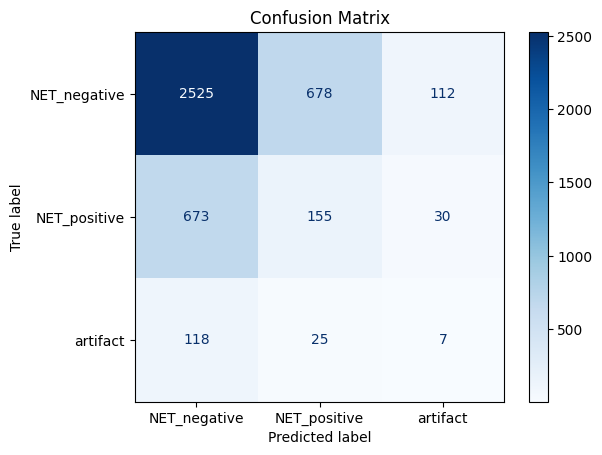

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = 'vgg16_nets_model_v2.h5'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_all'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.Precision()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


I will now try to change the ratio of the images. I only use the data augmentation for the positives and artifacts, while using the original data for the negatives.

Found 744 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.1775 - precision: 0.9126

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 240s 10s/step - loss: 0.1775 - precision: 0.9126 - val_loss: 0.0451 - val_precision: 0.9849
Epoch 2/20
24/24 [==============================] - 8s 327ms/step - loss: 0.0302 - precision: 0.9919 - val_loss: 0.0286 - val_precision: 0.9935
Epoch 3/20
24/24 [==============================] - 7s 279ms/step - loss: 0.0151 - precision: 0.9946 - val_loss: 0.0148 - val_precision: 1.0000
Epoch 4/20
24/24 [==============================] - 7s 278ms/step - loss: 0.0091 - precision: 1.0000 - val_loss: 0.0168 - val_precision: 0.9978
Epoch 5/20
24/24 [==============================] - 7s 297ms/step - loss: 0.0063 - precision: 1.0000 - val_loss: 0.0079 - val_precision: 1.0000
Epoch 6/20
24/24 [==============================] - 7s 290ms/step - loss: 0.0046 - precision: 1.0000 - val_loss: 0.0065 - val_precision: 1.0000
Epoch 7/20
24/24 [==============================] - 8s 306ms/step - loss: 0.0041 - precision: 1.0000 - val_loss: 0.0051 - val_precision: 1.0000
Epo

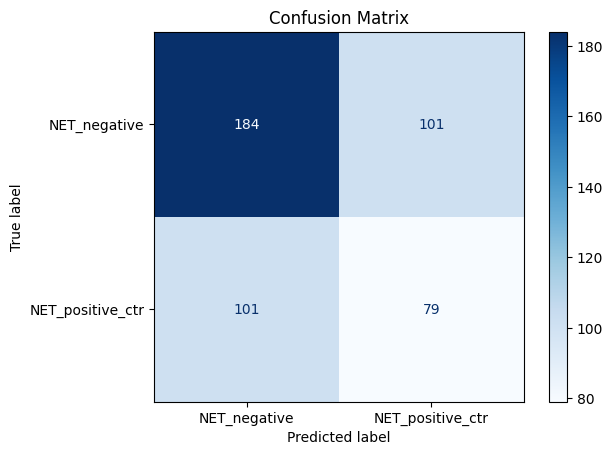

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = '/models'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_ctr'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.Precision()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 744 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.2221 - f1_score: 0.8763

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.97849, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V2_f1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 10s 315ms/step - loss: 0.2221 - f1_score: 0.8763 - val_loss: 0.0552 - val_f1_score: 0.9785
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.0455 - f1_score: 0.9812
Epoch 2: val_f1_score improved from 0.97849 to 0.99570, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V2_f1.h5
24/24 [==============================] - 8s 322ms/step - loss: 0.0455 - f1_score: 0.9812 - val_loss: 0.0313 - val_f1_score: 0.9957
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.0209 - f1_score: 0.9946
Epoch 3: val_f1_score improved from 0.99570 to 0.99785, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V2_f1.h5
24/24 [==============================] - 8s 316ms/step - loss: 0.0209 - f1_score: 0.9946 - val_loss: 0.0238 - val_f1_score: 0.9978
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 0.0131 - f1_score: 1.0000
Epoch 4: val_f1_score improv

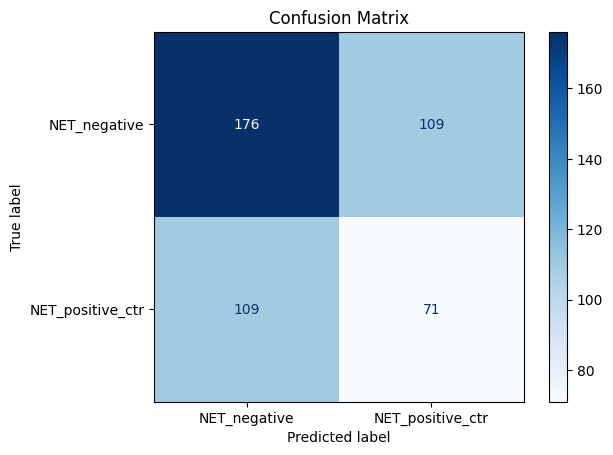

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/models'  # Directory to save the model
MODEL_PATH = os.path.join(MODEL_DIR, 'vgg16_nets_model_ctr_V2_f1.h5')  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_ctr'  # Path to the dataset

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[F1Score()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_f1_score', patience=5, restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_f1_score', mode='max', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)
print(f"Model saved at {MODEL_PATH}")

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'F1Score': F1Score})

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/models'  # Directory to save the model
MODEL_PATH = os.path.join(MODEL_DIR, 'vgg16_nets_model_ctr_V3_prec.h5')  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_ctr'  # Path to the dataset

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16 with Dropout and BatchNormalization
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Dropout layer with 50% rate
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.Precision()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)
print(f"Model saved at {MODEL_PATH}")

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'Precision': tf.keras.metrics.Precision})

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 744 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 1.0004 - precision: 0.9637 
Epoch 1: val_loss improved from inf to 0.90116, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V3_prec.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 715s 30s/step - loss: 1.0004 - precision: 0.9637 - val_loss: 0.9012 - val_precision: 0.9634
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.7457 - precision: 0.9892 
Epoch 2: val_loss improved from 0.90116 to 0.72903, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V3_prec.h5
24/24 [==============================] - 703s 30s/step - loss: 0.7457 - precision: 0.9892 - val_loss: 0.7290 - val_precision: 0.9591
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.6029 - precision: 0.9987 
Epoch 3: val_loss improved from 0.72903 to 0.61981, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V3_prec.h5
24/24 [==============================] - 693s 29s/step - loss: 0.6029 - precision: 0.9987 - val_loss: 0.6198 - val_precision: 0.9634
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 0.5242 - precision: 0.9960 
Epoch 4: val_loss imp

Found 1076 images belonging to 2 classes.
Found 268 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.9709 - precision: 0.9563
Epoch 1: val_loss improved from inf to 0.94171, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V4_prec.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 310s 9s/step - loss: 0.9709 - precision: 0.9563 - val_loss: 0.9417 - val_precision: 0.8914
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.6643 - precision: 0.9954
Epoch 2: val_loss improved from 0.94171 to 0.63471, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V4_prec.h5
34/34 [==============================] - 17s 503ms/step - loss: 0.6643 - precision: 0.9954 - val_loss: 0.6347 - val_precision: 0.9777
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.5381 - precision: 0.9991
Epoch 3: val_loss improved from 0.63471 to 0.50249, saving model to /content/drive/MyDrive/Colab Notebooks/models/vgg16_nets_model_ctr_V4_prec.h5
34/34 [==============================] - 10s 288ms/step - loss: 0.5381 - precision: 0.9991 - val_loss: 0.5025 - val_precision: 0.9985
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.4639 - precision: 0.9963
Epoch 4: val_loss impro

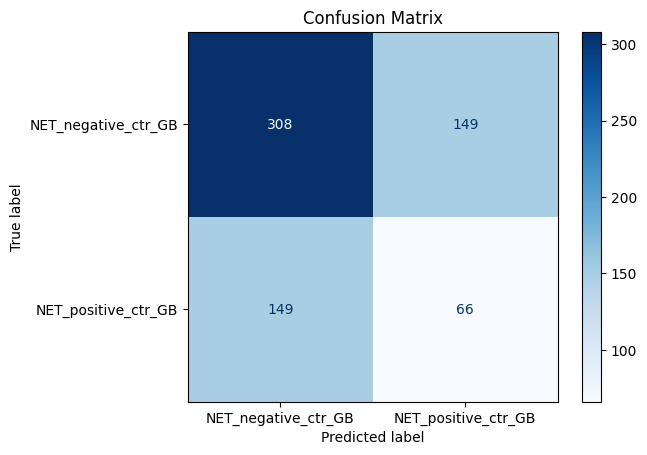

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/models'  # Directory to save the model
MODEL_PATH = os.path.join(MODEL_DIR, 'vgg16_nets_model_ctr_V4_prec.h5')  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_ctr_GB'  # Path to the dataset

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16 with Dropout and BatchNormalization
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Dropout layer with 50% rate
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.Precision()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)
print(f"Model saved at {MODEL_PATH}")

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'Precision': tf.keras.metrics.Precision})

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 1076 images belonging to 2 classes.
Found 268 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
21/21 [==============================] - 442s 21s/step
                                            Filename  TrueLabel  \
0  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   
1  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   
2  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   
3  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   
4  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   

   ProbCategory0  ProbCategory1  
0   9.999421e-01       0.000058  
1   9.998324e-01       0.000168  
2   9.999128e-01       0.000087  
3   9.999824e-01       0.000018  
4   6.560778e-11       1.000000  
Classification Report:
                      precision    recall  f1-score   support

NET_negative_ctr_GB       0.70      0.70      0.70       457
NET_positive_ctr_GB       

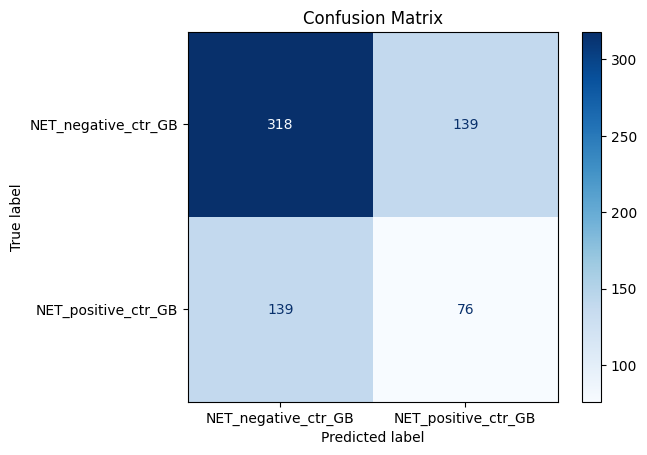

In [ ]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/models'  # Directory to save the model
MODEL_PATH = os.path.join(MODEL_DIR, 'vgg16_nets_model_ctr_V4_prec.h5')  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_ctr_GB'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load the trained model with custom objects if any
model = load_model(MODEL_PATH, custom_objects={'Precision': tf.keras.metrics.Precision})

# Make predictions
predictions = model.predict(test_generator)

# Apply custom threshold logic to adjust predictions
predicted_classes = np.argmax(predictions, axis=1)  # Default class based on highest probability
#for i in range(len(predictions)):
#    if predictions[i][1] >= THRESHOLD:  # Assuming class 2 corresponds to index 1
#        predicted_classes[i] = 1  # Force into category 2 if probability is >= threshold

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Create a DataFrame with image filenames, true labels, and predicted probabilities
filenames = test_generator.filenames
prob_category_0 = predictions[:, 0]
prob_category_1 = predictions[:, 1]

data = {
    'Filename': filenames,
    'TrueLabel': true_classes,
    'ProbCategory0': prob_category_0,
    'ProbCategory1': prob_category_1
}

df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file
df.to_csv('predictions_with_probabilities.csv', index=False)

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 1076 images belonging to 2 classes.
Found 268 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Found 672 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
                      precision    recall  f1-score   support

NET_negative_ctr_GB       1.00      1.00      1.00       457
NET_positive_ctr_GB       0.99      1.00      0.99       215

           accuracy                           1.00       672
          macro avg       0.99      1.00      0.99       672
       weighted avg       1.00      1.00      1.00       672



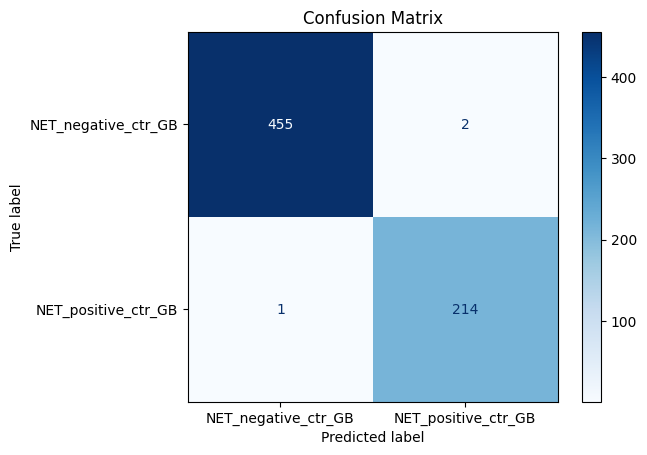

In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_ctr_GB'

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

# Function to extract features and labels from the generator
def extract_features(generator):
    features = []
    labels = []
    for _ in range(len(generator)):
        batch_features, batch_labels = generator.next()
        batch_features = batch_features.reshape((batch_features.shape[0], -1))  # Flatten the images
        features.append(batch_features)
        labels.append(batch_labels)
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, np.argmax(labels, axis=1)

# Extract features and labels
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)
X_test, y_test = extract_features(test_generator)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Create a logistic regression model with a pipeline for standardization and PCA for dimensionality reduction
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),  # Reduce dimensionality to 100 components for faster training
    ('logistic', LogisticRegression(class_weight=class_weights, max_iter=1000))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate precision, recall, F1 score
report = classification_report(y_test, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 1076 images belonging to 2 classes.
Found 268 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Scaler saved to /content/drive/MyDrive/Colab Notebooks/models/scaler_colab.pkl
PCA saved to /content/drive/MyDrive/Colab Notebooks/models/pca_colab.pkl
Model saved to /content/drive/MyDrive/Colab Notebooks/models/logistic_regression_model_colab.pkl
Model loaded successfully
Classification Report:
                      precision    recall  f1-score   support

NET_negative_ctr_GB       1.00      1.00      1.00       457
NET_positive_ctr_GB       1.00      1.00      1.00       215

           accuracy                           1.00       672
          macro avg       1.00      1.00      1.00       672
       weighted avg       1.00      1.00      1.00       672



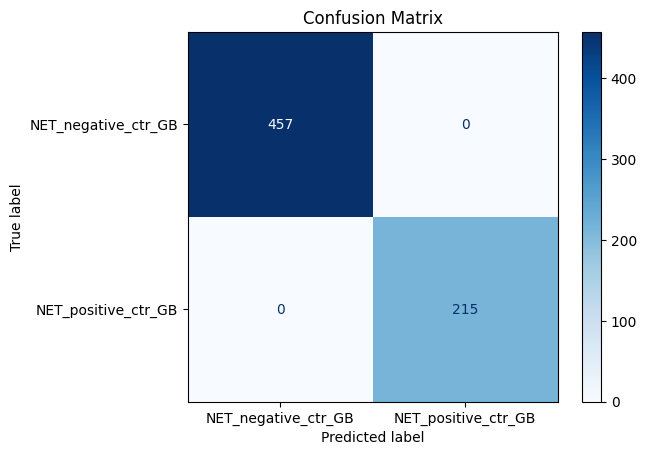

In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib  # Import joblib to save the model

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_ctr_GB'
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/models/logistic_regression_model_colab.pkl'  # Path to save the model
SCALER_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/models/scaler_colab.pkl'
PCA_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/models/pca_colab.pkl'

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

# Function to extract features and labels from the generator
def extract_features(generator):
    features = []
    labels = []
    for _ in range(len(generator)):
        batch_features, batch_labels = generator.next()
        batch_features = batch_features.reshape((batch_features.shape[0], -1))  # Flatten the images
        features.append(batch_features)
        labels.append(batch_labels)
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, np.argmax(labels, axis=1)

# Extract features and labels
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)
X_test, y_test = extract_features(test_generator)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Create and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, SCALER_SAVE_PATH)
print(f"Scaler saved to {SCALER_SAVE_PATH}")

# Create and fit the PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
joblib.dump(pca, PCA_SAVE_PATH)
print(f"PCA saved to {PCA_SAVE_PATH}")

# Create a logistic regression model with L2 regularization
model = LogisticRegression(class_weight=class_weights, max_iter=1000, penalty='l2', C=1.0)

# Train the model
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Load the model (optional, for demonstration)
loaded_model = joblib.load(MODEL_SAVE_PATH)
print("Model loaded successfully")

# Evaluate the model
y_pred = loaded_model.predict(X_test)

# Calculate precision, recall, F1 score
report = classification_report(y_test, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Predicted class: NET_negative_ctr_GB
Prediction probabilities: [[9.99999999e-01 5.83854949e-10]]


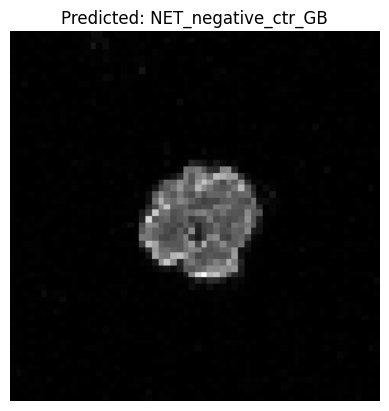

(0, array([[9.99999999e-01, 5.83854949e-10]]))

In [ ]:
# Function to predict the class of a specific image and display it
def predict_and_display_image(image_path, model, img_size=IMG_SIZE):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, -1))  # Flatten the image
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    prediction_prob = model.predict_proba(img_array)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]

    # Get the class labels
    class_labels = list(train_generator.class_indices.keys())

    # Print the results
    print(f"Predicted class: {class_labels[predicted_class]}")
    print(f"Prediction probabilities: {prediction_prob}")

    # Display the image
    plt.imshow(img_array.reshape(img_size), cmap='gray')
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

    return predicted_class, prediction_prob

# Predict the class of a specific image from the test set
image_path = os.path.join(DATASET_PATH, test_generator.filenames[3])  # Change the index to test other images
predict_and_display_image(image_path, model)


In [ ]:
# Generate a DataFrame and CSV file with predictions
filenames = test_generator.filenames
predictions = model.predict_proba(X_test)
predicted_classes = np.argmax(predictions, axis=1)

data = {
    'Filename': filenames,
    'TrueLabel': y_test,
    'PredictedLabel': predicted_classes,
    'ProbCategory0': predictions[:, 0],
    'ProbCategory1': predictions[:, 1]
}

df = pd.DataFrame(data)
print(df.head())

# Save the DataFrame to a CSV file
df.to_csv('predictions_with_probabilities_lr.csv', index=False)
print("CSV file 'predictions_with_probabilities_lr.csv' saved.")

                                            Filename  TrueLabel  \
0  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   
1  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   
2  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          1   
3  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   
4  NET_negative_ctr_GB/20211111.lif_ctr_27.10.21N...          0   

   PredictedLabel  ProbCategory0  ProbCategory1  
0               0       0.955151   4.484866e-02  
1               0       1.000000   2.056658e-13  
2               1       0.119546   8.804537e-01  
3               0       1.000000   5.923215e-11  
4               0       1.000000   6.214127e-13  
CSV file 'predictions_with_probabilities_lr.csv' saved.


In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, learning_curve
import matplotlib.pyplot as plt
import joblib
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/modified_dataset_subimaging'
# Data generator with train-test split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'
)
validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'
)
# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)
test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)
# Function to convert grayscale to 3-channel
def to_rgb(img):
    return np.repeat(img, 3, axis=-1)
# Feature extraction using a pre-trained model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
feature_extractor = Model(inputs=base_model.input, outputs=x)
# Function to extract features and labels from the generator
def extract_features(generator, feature_extractor):
    features = []
    labels = []
    for _ in range(len(generator)):
        batch_features, batch_labels = generator.next()
        batch_features = np.array([to_rgb(img) for img in batch_features])  # Convert to RGB
        batch_features = feature_extractor.predict(batch_features)
        features.append(batch_features)
        labels.append(batch_labels)
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, np.argmax(labels, axis=1)
# Extract features and labels
X_train, y_train = extract_features(train_generator, feature_extractor)
X_val, y_val = extract_features(validation_generator, feature_extractor)
X_test, y_test = extract_features(test_generator, feature_extractor)
# Combine training and validation sets for cross-validation
X = np.vstack((X_train, X_val))
y = np.hstack((y_train, y_val))
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'pca__n_components': [50, 100, 150],
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    'logistic__solver': ['lbfgs', 'sag', 'saga']
}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logistic', LogisticRegression(class_weight=class_weights, max_iter=10000))  # Increase max_iter
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
# Evaluate the model using cross-validation
scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
# Train-test split for final evaluation
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
best_model.fit(X_train, y_train)
# Evaluate the model
y_pred = best_model.predict(X_val_test)
report = classification_report(y_val_test, y_pred, target_names=train_generator.class_indices.keys())
print("Classification Report:\n", report)
# Compute and plot confusion matrix
cm = confusion_matrix(y_val_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
# Plot learning curves
def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.show()
plot_learning_curve(best_model, X, y)
# Save the model
model_filename = '/content/drive/MyDrive/Colab Notebooks/best_model_logreg_Resnet.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

Found 2433 images belonging to 2 classes.
Found 608 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.
Found 1521 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step


In [ ]:
# Function to predict the class of a specific image and display it
def predict_and_display_image(image_path, model, img_size=IMG_SIZE):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, -1))  # Flatten the image
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    prediction_prob = model.predict_proba(img_array)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]

    # Get the class labels
    class_labels = list(train_generator.class_indices.keys())

    # Print the results
    print(f"Predicted class: {class_labels[predicted_class]}")
    print(f"Prediction probabilities: {prediction_prob}")

    # Display the image
    plt.imshow(img_array.reshape(img_size), cmap='gray')
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

    return predicted_class, prediction_prob

# Predict the class of a specific image from the test set
image_path = os.path.join(DATASET_PATH, test_generator.filenames[3])  # Change the index to test other images
predict_and_display_image(image_path, model)


NameError: name 'IMG_SIZE' is not defined

In [ ]:
# Generate a DataFrame and CSV file with predictions
filenames = test_generator.filenames
predictions = model.predict_proba(X_test)
predicted_classes = np.argmax(predictions, axis=1)

data = {
    'Filename': filenames,
    'TrueLabel': y_test,
    'PredictedLabel': predicted_classes,
    'ProbCategory0': predictions[:, 0],
    'ProbCategory1': predictions[:, 1]
}

df = pd.DataFrame(data)
print(df.head())

# Save the DataFrame to a CSV file
df.to_csv('predictions_with_probabilities_lr.csv', index=False)
print("CSV file 'predictions_with_probabilities_lr.csv' saved.")